## Chapter 5 - Support Vector Machines

SVMs are very powerful and versatile ML models, able to perform linear or nonlinear classification, regression and outlier detection.

### Hyperplane 

In a $p$-dimensional space, a **hyperplane** is a flat affine subspace of dimensions $p-1$. In 2 dimensions, a hyperplane is defined as $\beta_0 + \beta_1x_1 + \beta_2x_2=0$. Generally, a hyperplane in $p$ dimensions is:
$$\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p=0$$ 
Given $\mathbf x = \begin{pmatrix}x_1 & x_2 & \cdots & x_p\end{pmatrix}$, if $\mathbf x$ does not satisfy the above equation then it does not lie on the hyperplane. It will lie on one side of the hyperplane if $\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p > 0$ and on the other if $\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p < 0$. So, we can think that a hyperplane separates a $p$-dimensional space into two halves and we can immediately determine which side a point lies relative to they hyperplane by calculating the result of $\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p$.

### Maximal Margin Classifier

Also known as hard margin classification. 

Given $n$ training examples, each with $p$ features $x_1, \cdots, x_n \in \mathbb R^p$ and their associated class labels $y_1, \cdots, y_n \in \{-1,1\}$, the maximum margin classifier is the solution to the optimisation problem:

$$\underset{\beta_0, \cdots, \beta_p}{\text{Maximise }}M \text{ s. t. }$$
$$\sum_{j=1}^p \beta_j^2=1$$
$$y_i(\beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + \cdots + \beta_px_{ip}) \geq M \,\,\forall i \in \{1,\cdots,n\}$$

The constraint in the third equation guarantees that each observation is on the correct side of the hyperplane given than $M>0$. Also, the constraint in the 2nd equation is needed so the perpendicular distances from the $i$th observation to the hyperplane is $y_i(\beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + \cdots + \beta_px_{ip})$. Combined, they ensure that each observation is on the right side of the hyperplane and at least a distance $M$ from the hyperplane, and the optimisation problem chooses $\beta_0, \beta_1, \cdots, \beta_p$ to maximise this margin $M$.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import (make_moons, load_iris)
from sklearn.preprocessing import (PolynomialFeatures, StandardScaler)
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.model_selection import train_test_split

In [2]:
# Ingest
iris_dataset = load_iris()
X = pd.DataFrame(iris_dataset['data'], columns=iris_dataset['feature_names'])
y = pd.Series(iris_dataset['target'])
y_names = pd.Series(iris_dataset['target_names'][i] for i in y)

df = X.join(pd.DataFrame(y_names, columns=['y_name']))

In [3]:
# For testing
# display(X.head(2))
# display(y.head(2))
# display(y_names.head(2))
# display(df.head(2))

Consider the Iris dataset. When looking at the scatterplot of the dataset, it is clear that these 2 classes are easily linearly separable.

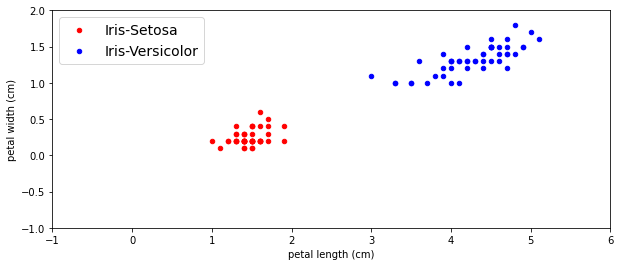

In [4]:
# Scatterplot for only setosa and versicolor
fig, ax = plt.subplots(figsize=(10,4))
df[df.y_name=='setosa'].plot(kind='scatter', x='petal length (cm)', y='petal width (cm)', ax=ax, color='red')
df[df.y_name=='versicolor'].plot(kind='scatter', x='petal length (cm)', y='petal width (cm)', ax=ax, color='blue')
ax.set_ylim(-1,2)
ax.set_xlim(-1,6)
ax.legend(['Iris-Setosa', 'Iris-Versicolor'], fontsize=14)
plt.show()

The maximum margin classifier is built to get the widest street possible, making sure the line stays as far away from the closest training instances.

In [5]:
# Train
df_ex1 = pd.concat([df[df.y_name=='setosa'], df[df.y_name=='versicolor']])
X_ex1 = df_ex1[['petal length (cm)', 'petal width (cm)']]
y_ex1 = df_ex1['y_name']

clf_ex1 = SVC(kernel='linear', C=float('inf')) # Find the maximum margin classifier
clf_ex1.fit(X_ex1, y_ex1)

SVC(C=inf, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [6]:
# For testing
# print(clf_ex1.coef_[0])
# print(clf_ex1.intercept_)
# print(clf_ex1.support_vectors_)
# print(clf_ex1.support_vectors_.reshape(-2,2))

In [7]:
# Obtain the support vectors and the decision boundary
xmin, xmax = 0,5
x0 = np.linspace(0,5)

w = clf_ex1.coef_[0]
b = clf_ex1.intercept_[0]

# At the decision boundary, w0*x0 + w1*x1 + b = 0
# => x1 = -w0/w1 * x0 - b/w1
x0 = np.linspace(xmin, xmax, 200)
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin
line_df_ex1 = pd.DataFrame({'x' : x0, 'd' : decision_boundary, 'g_up' : gutter_up, 'g_down' : gutter_down})

sv_df_ex1 = pd.DataFrame(clf_ex1.support_vectors_, columns=['x', 'y'])

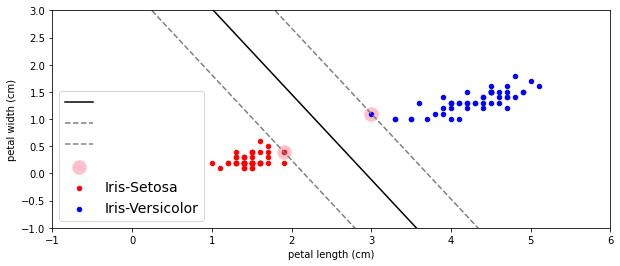

In [8]:
# Plotting the SVM classifier with the dataset
fig, ax = plt.subplots(figsize=(10,4))
line_df_ex1.plot(color='black', kind='line', x='x', y='d', ax=ax)
line_df_ex1.plot(style='--',color='gray', kind='line', x='x', y='g_up',  ax=ax)
line_df_ex1.plot(style='--',color='gray', kind='line', x='x', y='g_down',  ax=ax)
sv_df_ex1.plot(x='x', y='y', kind='scatter', color='pink', s=180, ax=ax)
df[df.y_name=='setosa'].plot(kind='scatter', x='petal length (cm)', y='petal width (cm)', ax=ax, color='red')
df[df.y_name=='versicolor'].plot(kind='scatter', x='petal length (cm)', y='petal width (cm)', ax=ax, color='blue')
ax.legend(['', '', '', '', 'Iris-Setosa', 'Iris-Versicolor'], fontsize=14)
ax.set_ylim(-1,3)
ax.set_xlim(-1,6)

plt.show()

### Support Vector Classifier

Also known as soft margin classification.

In practice, the data is usually not linearly separable and is can be sensitive to outliers. Support vector classifiers is a generalisation of the maximal margin classifier such that it allows for wrongly classified examples. This allows it to be more robust to variations and not be too sensitive to outliers. This solution can also lead to less overfitting of the training data. Now, the support vector classifier is the solution to the optimisation problem:

$$\underset{\beta_0, \cdots, \beta_p,\epsilon_1, \cdots, \epsilon_n}{\text{Maximise }}M \text{ s. t. }$$
$$\sum_{j=1}^p \beta_j^2=1$$
$$y_i(\beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + \cdots + \beta_px_{ip}) \geq M(1-\epsilon_i) 
\,\,\forall i \in \{1,\cdots,n\}$$
$$\epsilon_i \geq 0\,\,\forall i \in \{1,\cdots,n\}\,\,, \sum_{i=1}^n \epsilon_i \leq C$$

where $C$ is a nonnegative tuning parameter. $\epsilon_i$ are slack variables that allow observations to be on the wrong side of the margin, or more severely the hyperplane.

- If $\epsilon_i=0$, then $M(1-\epsilon_i)=M$ and this observation is on the right side of the margin (and hyperplane)
- If $0<\epsilon_i<1$, then $0<M(1-\epsilon_i)<M$ and this observation is on the wrong side of 
the margin (but still the right side of the hyperplane)
- If $\epsilon_i>1$, then $M(1-\epsilon_i)<0$ and this observation is on the wrong side of the hyperplane and is wrongly classified.

The role of $C$ is the amount that the margin can be violated from the $n$ observations. The extent of violations can be observed by the sum $\sum_{i=1}^n \epsilon_i$. 

If $C=0$ then there is no room for violations and this is the same as the maximal margin classifier. If $C>0$ then there can be no more than $C$ observations on the wrong side of the hyperplane. A small $C$ results in a small tolerance of violations. As $C$ increases, we become more tolerant of violations to the margin.

In practice, $C$ is generally treated as a tuning parameter chosen via cross-validation.

In sklearn, this can be controlled using the `C` parameter. A high `C` value actually results in a smaller $C$, while a low `C` results in a larger $C$.

In [9]:
# Ingest
expt1_X = df[['petal length (cm)', 'petal width (cm)']]
expt1_y = y==2
expt1_y = expt1_y.apply(lambda x : 1 if x else 0)
expt1_df = pd.DataFrame({'petal length (cm)' : expt1_X['petal length (cm)'],
                         'petal width (cm)' : expt1_X['petal width (cm)'],
                         'result' : expt1_y})

# Preprocessing
scaler = StandardScaler()
expt1_X_sc = scaler.fit_transform(expt1_X)

expt1_X_sc_df = pd.DataFrame(expt1_X_sc, columns=['length__scaled', 'width__scaled'])
expt1_df = expt1_df.copy().join(expt1_X_sc_df)

In [10]:
# For testing
# expt1_df.head(3)

In [11]:
# Train for 2 models of differing C
clf_expt11 = LinearSVC(C=1, loss='hinge')
clf_expt11.fit(expt1_df[['length__scaled', 'width__scaled']], expt1_df['result'])

clf_expt12 = LinearSVC(C=100, loss='hinge')
clf_expt12.fit(expt1_df[['length__scaled', 'width__scaled']], expt1_df['result'])

LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [12]:
# Predict using both models
X_test = [[5.5,1.7]]
X_test_scl = scaler.transform(X_test)

print(clf_expt11.predict(X_test_scl))
print(clf_expt12.predict(X_test_scl))

[1]
[1]


In [13]:
# Obtain the support vectors and the decision boundary
xmin, xmax = 0,5
x0 = np.linspace(0,5)

w_e1 = clf_expt11.coef_[0]
b_e1 = clf_expt11.intercept_[0]
decision_boundary_e1 = -w_e1[0]/w_e1[1] * x0 - b_e1/w_e1[1]
margin_e1 = 1/w_e1[1]
gutter_up_e1 = decision_boundary_e1 + margin_e1
gutter_down_e1 = decision_boundary_e1 - margin_e1
line_df_expt1 = pd.DataFrame({'x' : x0, 'd' : decision_boundary_e1, 
                            'g_up' : gutter_up_e1, 
                            'g_down' : gutter_down_e1})


w_e2 = clf_expt12.coef_[0]
b_e2 = clf_expt12.intercept_[0]
decision_boundary_e2 = -w_e2[0]/w_e2[1] * x0 - b_e2/w_e2[1]
margin_e2 = 1/w_e2[1]
gutter_up_e2 = decision_boundary_e2 + margin_e2
gutter_down_e2 = decision_boundary_e2 - margin_e2

line_df_expt2 = pd.DataFrame({'x' : x0, 'd' : decision_boundary_e2, 
                            'g_up' : gutter_up_e2, 
                            'g_down' : gutter_down_e2})

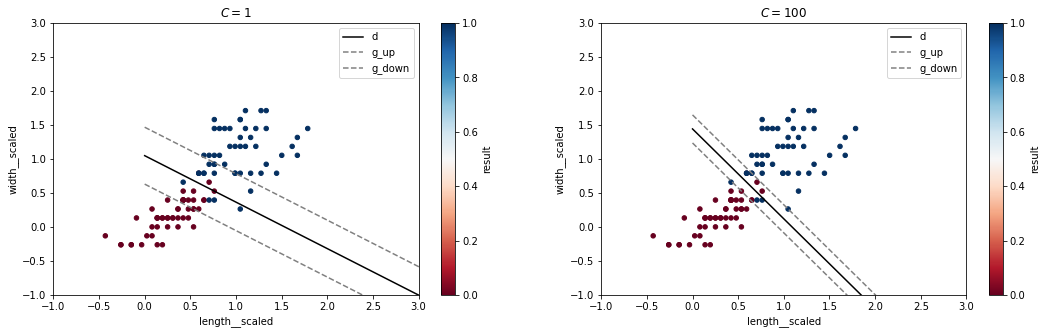

In [14]:
# Visualise the soft margin classifier
fig= plt.figure(figsize=(18,5))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
line_df_expt1.plot(color='black', kind='line', x='x', y='d', ax=ax1)
line_df_expt1.plot(style='--',color='gray', kind='line', x='x', y='g_up',  ax=ax1)
line_df_expt1.plot(style='--',color='gray', kind='line', x='x', y='g_down',  ax=ax1)
expt1_df.plot(kind='scatter', x='length__scaled', y='width__scaled', c='result',
              colormap='RdBu', ax=ax1)
ax1.set_xlim(-1,3)
ax1.set_ylim(-1,3)
ax1.set_title("$C=1$")

line_df_expt2.plot(color='black', kind='line', x='x', y='d', ax=ax2)
line_df_expt2.plot(style='--',color='gray', kind='line', x='x', y='g_up',  ax=ax2)
line_df_expt2.plot(style='--',color='gray', kind='line', x='x', y='g_down',  ax=ax2)
expt1_df.plot(kind='scatter', x='length__scaled', y='width__scaled', c='result',
              colormap='RdBu', ax=ax2)
ax2.set_xlim(-1,3)
ax2.set_ylim(-1,3)
ax2.set_title("$C=100$")

plt.show()

The instances that lie on the edge of the street are called the support vectors. 
<hr>